```
The MIT License (MIT)

Copyright (c) 2020 NVIDIA

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

```

# Model Converstion to NVIDIA TensorRT & Inference

Walthrough a generic pipeline for:
- Converting a Pytorch network to TensorRT (via ONNX)
- With and without dynamic batch
- Steps for Running inference using a TensorRT engine in Python

#### Environment
All steps executed using **NGC Pytorch Docker (v 20.06)**
* [GPU Dashboards](https://medium.com/rapids-ai/gpu-dashboards-in-jupyter-lab-757b17aae1d5) installed using
```
pip install jupyterlab-nvdashboard
jupyter labextension install jupyterlab-nvdashboard
```
* [Netron](https://github.com/lutzroeder/netron) for network visualization

In [1]:
import numpy as np
import torch
import json
from pathlib import Path
from PIL import Image
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.autograd import Variable
import numpy as np
import pandas as pd
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import sys
import os 
import numpy as np

#### Dataset
* [NIH ChestXray 14 dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)
* 112,120 frontal view chest xrays from 30,805 unique subjects
* X-ray images are available as bitmaps extracted from the DICOM file

In [4]:
def getData(filname):
    # images are 48x48 = 2304 size vectors
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X) / 255.0, np.array(Y) # scaling is already done here
    X=X.reshape(35887,1,48,48)
    return X,Y

def get_loader(X,Y,bz):
    tensor_X = torch.stack([torch.from_numpy(np.array(i)) for i in X])
    tensor_y = torch.stack([torch.from_numpy(np.array(i)) for i in Y])

    train_dataset = torch.utils.data.TensorDataset(tensor_X, tensor_y)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=bz)
    return train_loader

In [6]:
bs = 8 
X,Y = getData('./NB_images/fer2013.csv')
print(X.shape, Y.shape)
train_loader = get_loader(X,Y,bs)

(35887, 1, 48, 48) (35887,)


In [9]:
np.unique(Y,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([4953,  547, 5121, 8989, 6077, 4002, 6198]))

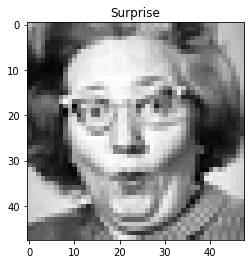

In [15]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
rn=random.randint(0,len(X)-1)

num2label={0:'Anger', 1:'Disgust',2:'Fear', 3:'Happy',4: 'Sad', 5:'Surprise', 6:'Neutral'}
plt.imshow(np.squeeze(X[rn]), cmap='gray')
plt.title(num2label[Y[rn]])
plt.show()


### Model

In [16]:
from torch import nn
import torchvision.models as models


num_classes = 7
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #44x(48-5+1)(48-5+1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 24, 5)
        self.fc1 = nn.Linear(24 * 9 * 9, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
                num_features *=s
        return num_features

use_gpu=True
if use_gpu:  
    device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu") # train on gpu number 0 
    print("using GPU device ", device )


# construct the model and move to GPU if using GPU to train
net=Net()
if use_gpu:
    torch.cuda.set_device(device)
    net.cuda()
    criterion = nn.CrossEntropyLoss().cuda(device)
else:
    criterion = nn.CrossEntropyLoss()    
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)




using GPU device  cuda:0


In [19]:
def train_fn(train_loader,net, optimizer,criterion, epochs):   
    for e in range(epochs):
        running_loss =0
        correct = 0
        total = 0
        collect_normalizer=0
        for i, data in enumerate(train_loader):
            #print(i, len(data), data[0]['data'].size(), data[0]['label'].size())
            #print(i, data[0]['data'].permute(0, 3, 1, 2).size(), data[0]['label'].size())
            inputs = data[0].to(device)
            labels = data[1].squeeze().type(torch.LongTensor).to(device)
            #print(inputs.size(), labels.size())
            # zero the parameter gradients
            collect_normalizer += len(data[0])
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            pred,predicted =torch.max(outputs.data,1)
            pred_list=predicted.data.tolist()
            correct += (predicted == labels).sum().item()
            #acc=round(100 * correct / len(data[0]["data"]),4)
            #print(outputs.size())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            #print("loss is",loss.item())
            running_loss += loss.item()
            #print(collect_normalizer)
        print('Epoch [{}/{}],  ACC {:.4f}'.format(e + 1, epochs, correct / collect_normalizer ))

    return net, optimizer, train_loader

In [21]:
epochs=25
net, optimizer, train_loader =train_fn(train_loader, net, optimizer,criterion, epochs)

Epoch [1/25],  ACC 0.9112
Epoch [2/25],  ACC 0.9201
Epoch [3/25],  ACC 0.9204
Epoch [4/25],  ACC 0.9310
Epoch [5/25],  ACC 0.9339
Epoch [6/25],  ACC 0.9373
Epoch [7/25],  ACC 0.9405
Epoch [8/25],  ACC 0.9404
Epoch [9/25],  ACC 0.9417
Epoch [10/25],  ACC 0.9433
Epoch [11/25],  ACC 0.9479
Epoch [12/25],  ACC 0.9520
Epoch [13/25],  ACC 0.9488
Epoch [14/25],  ACC 0.9533
Epoch [15/25],  ACC 0.9555
Epoch [16/25],  ACC 0.9605
Epoch [17/25],  ACC 0.9565
Epoch [18/25],  ACC 0.9599
Epoch [19/25],  ACC 0.9648
Epoch [20/25],  ACC 0.9677
Epoch [21/25],  ACC 0.9669
Epoch [22/25],  ACC 0.9652
Epoch [23/25],  ACC 0.9689
Epoch [24/25],  ACC 0.9645
Epoch [25/25],  ACC 0.9661


In [23]:
# save model
torch.save({
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),

            }, './ckpt/model.pt')

In [27]:
#load model
loaded_model = Net()
optimizer = optim.SGD(loaded_model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load('./ckpt/model.pt')
loaded_model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

loaded_model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1944, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=7, bias=True)
)

In [29]:
input_names=['input']
output_names=['output']
dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}

# A dummy input is needed to generate the ONNX model
# Using NCHW format
dummy_input = torch.randn(8, 1, 48,48) 

# No dynamic batch dimension
torch.onnx.export(loaded_model, dummy_input, "./ckpt/model_weights.onnx", verbose=False, 
                  input_names=input_names, output_names=output_names)

# With dynamic batch dimension
torch.onnx.export(loaded_model, dummy_input, "./ckpt/model_weights_dynamicbatch.onnx", verbose=False, 
                  input_names=input_names, output_names=output_names, dynamic_axes=dynamic_axes)

In [30]:
import onnx
#Load the ONNX Model
model_onnx = onnx.load("./ckpt/model_weights_dynamicbatch.onnx")

# # Check that the IR is well formed
onnx.checker.check_model(model_onnx)

# # Print a human readable representation of the graph
# onnx.helper.printable_graph(model_onnx.graph)

In [32]:
!ls -lh ./ckpt/*.onnx

-rw-r--r-- 1 root root 1.1M Aug 17 10:07 ./ckpt/model_weights.onnx
-rw-r--r-- 1 root root 1.1M Aug 17 10:07 ./ckpt/model_weights_dynamicbatch.onnx


**Check the ONNX network in Netron (at http://localhost:8080/)**

### Test inference

In [36]:

for i,data in enumerate(train_loader):
    if i<=2:
        im=data[0].to(device)
        lb=data[1].squeeze().type(torch.LongTensor)
        print(im.size(),lb)
        
    else:
        break

torch.Size([8, 1, 48, 48]) tensor([0, 0, 2, 4, 6, 2, 4, 3])
torch.Size([8, 1, 48, 48]) tensor([3, 2, 0, 6, 6, 6, 3, 5])
torch.Size([8, 1, 48, 48]) tensor([3, 2, 6, 4, 4, 2, 0, 0])


In [48]:
im.cpu().detach().numpy().shape

(8, 1, 48, 48)

### Pytorch

In [42]:
loaded_model.eval()
loaded_model.cuda()
with torch.no_grad():
    outputs_pyt = loaded_model(im)
    outputs_pyt=torch.argmax(outputs_pyt,dim=0)
    print(outputs_pyt)

tensor([6, 5, 5, 0, 3, 1, 2], device='cuda:0')


### ONNX

In [61]:
#Run ONNX inference
import onnxruntime as ort

#ort_session = ort.InferenceSession('./ckpt/model_weights.onnx')
ort_session = ort.InferenceSession('./ckpt/model_weights_dynamicbatch.onnx')


def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy().astype('float32') 
# adding .astype('float32') refer to this issue http://www.xavierdupre.fr/app/onnxruntime/helpsphinx/auto_examples/plot_common_errors.html

# compute ONNX Runtime output prediction
print(to_numpy(im).shape, type(to_numpy(im)))

ort_outs = ort_session.run(None, {'input': to_numpy(im)})

img_out_y = ort_outs[0] # 'input is the layer name specified earlier'
np.argmax(img_out_y,axis=0)

(8, 1, 48, 48) <class 'numpy.ndarray'>


array([6, 5, 5, 0, 3, 1, 2])

(8, 7)

# TensorRT

### Key Concepts
**Network Definition**: interface provides methods for the application to specify the definition of a network.

**Builder Configuration**: interface specifies details for creating an engine.

**Builder**: allows the creation of an optimized engine from a network definition and a builder configuration.

**Engine**: allows the application to execute inference. It supports synchronous and asynchronous execution, profiling, and enumeration and querying of the bindings for the engine inputs and outputs.

An **Optimization profile** specifies constraints on dynamic dimensions. It describes a range of dimensions for each network input and the dimensions that the auto-tuner should use for optimization. When using runtime dimensions, you must create at least one optimization profile at build time. Two profiles can specify disjoint or overlapping ranges.

For example, one profile might specify a minimum size of [3,100,200], a maximum size of [3,200,300], and optimization dimensions of [3,150,250] while another profile might specify min, max and optimization dimensions of [3,200,100], [3,300,400], and [3,250,250].



> Note, if your TensorRT engine has fixed batch size and input shapes, then you **do not** need to worry about optimization profile(s)



### Note

*Implicit batch* networks were previously the standard up until TensorRT 6. They supported variable batch size through the use of the builder.maxBatchSize attribute, but do not support variable shapes for any of the other dimensions.

*Explicit Batch* networks introduced a few changes to the TensorRT API. 
First, inference is instead performed using execute_v2(bindings) and execute_async_v2(bindings, stream) , which no longer require a batch_size argument since it is taken from the context binding dimensions explicitly.

## Convert Model to TRT

Sample commands

Simple network with no dynamic batch dimension
```
trtexec --explicitBatch \
            --onnx=model_weights.onnx \
            --saveEngine=trt_export.engine 
```

With dynamic batch
``` 
trtexec --explicitBatch \
            --onnx=model_weights_dynamicbatch.onnx \
            --minShapes=input:1x1x48x48 \
            --optShapes=input:4x1x48x48 \
            --maxShapes=input:8x1x48x48 \
            --shapes=input:4x1x48x48 \
            --saveEngine=trt_export_dynamicbatch.engine 
```

For generating and engine in FP16
``` 
trtexec --explicitBatch \
            --onnx=model_weights_dynamicbatch.onnx \
            --minShapes=input:1x1x48x48 \
            --optShapes=input:4x1x48x48 \
            --maxShapes=input:8x1x48x48 \
            --shapes=input:4x1x48x48 \
            --saveEngine=trt_export_dynamicbatch_fp16.engine \
            --fp16
```

In [62]:
cmd = 'trtexec --explicitBatch --onnx=./ckpt/model_weights_dynamicbatch.onnx --minShapes=input:1x1x48x48 --optShapes=input:8x1x48x48 --maxShapes=input:96x1x48x48 --shapes=input:80x3x224x224 --saveEngine=./ckpt/trt_export_dynamicbatch_own_model.engine'
print(cmd)
os.system(cmd)

trtexec --explicitBatch --onnx=./ckpt/model_weights_dynamicbatch.onnx --minShapes=input:1x1x48x48 --optShapes=input:8x1x48x48 --maxShapes=input:96x1x48x48 --shapes=input:80x3x224x224 --saveEngine=./ckpt/trt_export_dynamicbatch_own_model.engine


256

In [63]:
cmd = 'python onnx_to_tensorrt7.py --model=./ckpt/model_weights.onnx --output=model_trt_weights.engine'
print(cmd)
# os.system(cmd)

python onnx_to_tensorrt7.py --model=./ckpt/model_weights.onnx --output=model_trt_weights.engine


#### Inspect Engine

In [64]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

In [65]:
def load_engine(filename):
    # Load serialized engine file into memory
    with open(filename, 'rb') as f, trt.Runtime(trt.Logger(trt.Logger.WARNING)) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

def inspect_engine(engine):
    profile_meta = {}
    num_bindings_per_profile = engine.num_bindings // engine.num_optimization_profiles
    for profile_index in range(engine.num_optimization_profiles):
        start_binding = profile_index * num_bindings_per_profile
        end_binding = start_binding + num_bindings_per_profile
        
        binding_meta = {}
        for binding_index in range(start_binding, end_binding):
            key = "Binding {}".format(binding_index)
            binding_meta[key] = {
                "profile": profile_index,
                "binding_index": binding_index,
                "binding_shape": engine.get_binding_shape(binding_index),
                "binding_dtype": engine.get_binding_dtype(binding_index),
                "binding_name": engine.get_binding_name(binding_index),
            }

            if engine.binding_is_input(binding_index):
                binding_meta[key]["binding_type"] = "INPUT"
                binding_meta[key]["profile_shape"] = engine.get_profile_shape(profile_index, binding_index)
            else:
                binding_meta[key]["binding_type"] = "OUTPUT"

        profile_meta["Profile {}".format(profile_index)] = binding_meta

    from pprint import pprint
    pprint(profile_meta)

In [66]:
engine_path = './ckpt/trt_export_dynamicbatch_own_model.engine'
# Load a serialized engine into memory
engine = load_engine(engine_path)
# View various attributes of engine
inspect_engine(engine)

{'Profile 0': {'Binding 0': {'binding_dtype': DataType.FLOAT,
                             'binding_index': 0,
                             'binding_name': 'input',
                             'binding_shape': (-1, 1, 48, 48),
                             'binding_type': 'INPUT',
                             'profile': 0,
                             'profile_shape': [(1, 1, 48, 48),
                                               (8, 1, 48, 48),
                                               (96, 1, 48, 48)]},
               'Binding 1': {'binding_dtype': DataType.FLOAT,
                             'binding_index': 1,
                             'binding_name': 'output',
                             'binding_shape': (-1, 7),
                             'binding_type': 'OUTPUT',
                             'profile': 0}}}


In [67]:
# Create context, this can be re-used
context = engine.create_execution_context()
# Profile 0 (first profile) is used by default
context.active_optimization_profile = 0
print("Active Optimization Profile: {}".format(context.active_optimization_profile))

Active Optimization Profile: 0


#### Binding Indices and Shape

In [68]:
def get_binding_idxs(engine, profile_index):
    # Calculate start/end binding indices for current context's profile
    num_bindings_per_profile = engine.num_bindings // engine.num_optimization_profiles
    start_binding = profile_index * num_bindings_per_profile
    end_binding = start_binding + num_bindings_per_profile

    print("Engine/Binding Metadata")
    print("\tNumber of optimization profiles: {}".format(engine.num_optimization_profiles))
    print("\tNumber of bindings per profile: {}".format(num_bindings_per_profile))
    print("\tFirst binding for profile {}: {}".format(profile_index, start_binding))
    print("\tLast binding for profile {}: {}".format(profile_index, end_binding-1))


    # Separate input and output binding indices for convenience
    input_binding_idxs = []
    output_binding_idxs = []
    for binding_index in range(start_binding, end_binding):
        if engine.binding_is_input(binding_index):
            input_binding_idxs.append(binding_index)
        else:
            output_binding_idxs.append(binding_index)

    return input_binding_idxs, output_binding_idxs

In [69]:
# These binding_idxs can change if either the context or the 
# active_optimization_profile are changed
input_binding_idxs, output_binding_idxs = get_binding_idxs(engine, context.active_optimization_profile)
input_names = [engine.get_binding_name(binding_idx) for binding_idx in input_binding_idxs]

Engine/Binding Metadata
	Number of optimization profiles: 1
	Number of bindings per profile: 2
	First binding for profile 0: 0
	Last binding for profile 0: 1


In [70]:
def is_dynamic(shape):
    return any(dim is None or dim < 0 for dim in shape)

def get_image_inputs(engine, context, input_binding_idxs,seed=42):
    # Input data for inference
    host_inputs = []
    print("Generating Random Inputs")
    print("\tUsing random seed: {}".format(seed))
    np.random.seed(seed)
    for binding_index in input_binding_idxs:
        # If input shape is fixed, we'll just use it
        input_shape = context.get_binding_shape(binding_index)
        input_name = engine.get_binding_name(binding_index)
        print("\tInput [{}] shape: {}".format(input_name, input_shape))
        # If input shape is dynamic, we'll arbitrarily select one of the
        # the min/opt/max shapes from our optimization profile
        if is_dynamic(input_shape):
            profile_index = context.active_optimization_profile
            profile_shapes = engine.get_profile_shape(profile_index, binding_index)
            print("\tProfile Shapes for [{}]: [kMIN {} | kOPT {} | kMAX {}]".format(input_name, *profile_shapes))
            # 0=min, 1=opt, 2=max, or choose any shape, (min <= shape <= max)
            input_shape = profile_shapes[1]
            print("\tInput [{}] shape was dynamic, setting inference shape to {}".format(input_name, input_shape))

        host_inputs.append(np.random.random(input_shape).astype(np.float32))

    return host_inputs


In [71]:
# Generate random inputs based on profile shapes
host_inputs = get_image_inputs(engine, context, input_binding_idxs)

Generating Random Inputs
	Using random seed: 42
	Input [input] shape: (-1, 1, 48, 48)
	Profile Shapes for [input]: [kMIN (1, 1, 48, 48) | kOPT (8, 1, 48, 48) | kMAX (96, 1, 48, 48)]
	Input [input] shape was dynamic, setting inference shape to (8, 1, 48, 48)


In [72]:
# Allocate device memory for inputs. This can be easily re-used if the
# input shapes don't change
device_inputs = [cuda.mem_alloc(h_input.nbytes) for h_input in host_inputs]

# Copy host inputs to device, this needs to be done for each new input
for h_input, d_input in zip(host_inputs, device_inputs):
    cuda.memcpy_htod(d_input, h_input)

print("Input Metadata")
print("\tNumber of Inputs: {}".format(len(input_binding_idxs)))
print("\tInput Bindings for Profile {}: {}".format(context.active_optimization_profile, input_binding_idxs))
print("\tInput names: {}".format(input_names))
print("\tInput shapes: {}".format([inp.shape for inp in host_inputs]))

Input Metadata
	Number of Inputs: 1
	Input Bindings for Profile 0: [0]
	Input names: ['input']
	Input shapes: [(8, 1, 48, 48)]


In [73]:
def setup_binding_shapes(engine, context, host_inputs, input_binding_idxs,
                  output_binding_idxs, has_input_shape_changed=False):
    # Explicitly set the dynamic input shapes, so the dynamic output
    # shapes can be computed internally

    for host_input, binding_index in zip(host_inputs, input_binding_idxs):
        context.set_binding_shape(binding_index, host_input.shape)

    assert(context.all_binding_shapes_specified)

    host_outputs = [None] * len(output_binding_idxs)
    device_outputs = [None] * len(output_binding_idxs)
    for i, binding_index in enumerate(output_binding_idxs):
        output_shape = context.get_binding_shape(binding_index)
        # print("output_shape", output_shape)
        # Allocate buffers to hold output results after copying back to host
        host_outputs[i] = np.empty(output_shape, dtype=np.float32)
        # Allocate output buffers on device
        device_outputs[i] = cuda.mem_alloc(host_outputs[i].nbytes)

    return host_outputs, device_outputs

In [74]:
# This needs to be called everytime your input shapes change
# If your inputs are always the same shape (same batch size, etc.),
# then you will only need to call this once
host_outputs, device_outputs = setup_binding_shapes(
    engine, context, host_inputs, input_binding_idxs, output_binding_idxs,
)
output_names = [engine.get_binding_name(binding_idx) for binding_idx in output_binding_idxs]

print("Output Metadata")
print("\tNumber of Outputs: {}".format(len(output_binding_idxs)))
print("\tOutput names: {}".format(output_names))
print("\tOutput shapes: {}".format([out.shape for out in host_outputs]))
print("\tOutput Bindings for Profile {}: {}".format(context.active_optimization_profile, output_binding_idxs))

Output Metadata
	Number of Outputs: 1
	Output names: ['output']
	Output shapes: [(8, 7)]
	Output Bindings for Profile 0: [1]


### Run TRT inference!

In [75]:
# Bindings are a list of device pointers for inputs and outputs
bindings = device_inputs + device_outputs

# Inference
context.execute_v2(bindings)

# Copy outputs back to host to view results
for h_output, d_output in zip(host_outputs, device_outputs):
    cuda.memcpy_dtoh(h_output, d_output)

# View outputs
print("Inference Outputs Shape:", host_outputs[0].shape)

Inference Outputs Shape: (8, 7)


In [76]:
def get_trt_inference_outputs(context,host_inputs,host_outputs,device_inputs, device_outputs):
    if not isinstance(host_inputs, list) and isinstance(host_inputs, np.ndarray): host_inputs = [host_inputs]
    else: raise ValueError('host inputs must be list of numpy-nd arrays')
            
    for h_input, d_input in zip(host_inputs, device_inputs): # Copy new inputs
        cuda.memcpy_htod(d_input, h_input)
    
    bindings = device_inputs + device_outputs
    context.execute_v2(bindings)

    for h_output, d_output in zip(host_outputs, device_outputs):
        cuda.memcpy_dtoh(h_output, d_output)  # Get outputs from device
    
    return host_outputs


In [99]:
def process_prob2pred(model_output):
    print(len(model_output),model_output[0].shape)
    
    pred=np.argmax(model_output[0],axis=0)
    
    labels=np.array([num2label[o] for o in pred])
    return labels

In [100]:
result_trt_fp32 = get_trt_inference_outputs(context,to_numpy(im),host_outputs,device_inputs,device_outputs)
process_prob2pred(result_trt_fp32)


1 (8, 7)


array(['Neutral', 'Surprise', 'Surprise', 'Anger', 'Happy', 'Disgust',
       'Fear'], dtype='<U8')

In [26]:
del context
del engine

### FP16 inference

In [101]:
cmd = 'trtexec --explicitBatch --onnx=./ckpt/model_weights_dynamicbatch.onnx --minShapes=input:1x1x48x48 --optShapes=input:8x1x48x48 --maxShapes=input:96x1x48x48 --shapes=input:8x1x48x48 --saveEngine=./ckpt/trt_export_dynamic_ownmodel.engine --fp16'
# print(cmd)

In [102]:
!ls -lh ./ckpt/*.engine

-rw-r--r-- 1 root root 1.2M Aug 17 10:55 ./ckpt/trt_export_dynamicbatch_own_model.engine


In [104]:
engine = load_engine('./ckpt/trt_export_dynamicbatch_own_model.engine')
inspect_engine(engine)

context = engine.create_execution_context()
context.active_optimization_profile = 0

input_binding_idxs, output_binding_idxs = get_binding_idxs(engine, context.active_optimization_profile)

host_inputs = get_image_inputs(engine, context, input_binding_idxs)
device_inputs = [cuda.mem_alloc(h_input.nbytes) for h_input in host_inputs]

for h_input, d_input in zip(host_inputs, device_inputs):
    cuda.memcpy_htod(d_input, h_input)

# Placeholder for output buffers, will resize as necessary
host_outputs, device_outputs = setup_binding_shapes(engine, context, host_inputs,
                                                    input_binding_idxs, output_binding_idxs)
bindings = device_inputs + device_outputs

{'Profile 0': {'Binding 0': {'binding_dtype': DataType.FLOAT,
                             'binding_index': 0,
                             'binding_name': 'input',
                             'binding_shape': (-1, 1, 48, 48),
                             'binding_type': 'INPUT',
                             'profile': 0,
                             'profile_shape': [(1, 1, 48, 48),
                                               (8, 1, 48, 48),
                                               (96, 1, 48, 48)]},
               'Binding 1': {'binding_dtype': DataType.FLOAT,
                             'binding_index': 1,
                             'binding_name': 'output',
                             'binding_shape': (-1, 7),
                             'binding_type': 'OUTPUT',
                             'profile': 0}}}
Engine/Binding Metadata
	Number of optimization profiles: 1
	Number of bindings per profile: 2
	First binding for profile 0: 0
	Last binding for profile 0: 1
Gene

In [105]:
result_trt_fp16 = get_trt_inference_outputs(context,to_numpy(im),host_outputs,device_inputs,device_outputs)
process_prob2pred(result_trt_fp16)

1 (8, 7)


array(['Neutral', 'Surprise', 'Surprise', 'Anger', 'Happy', 'Disgust',
       'Fear'], dtype='<U8')

### Profiling

`nsys profile -y 0 -w true -t cudnn,cuda,osrt,nvtx -o Report.qdrep python run_inference.py`